# Predict Chronic Disease

In [1]:
# If additional packages are needed but are not installed by default, uncomment the last two lines of this cell
# and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

import sys
!{sys.executable} -m pip install word2number lightgbm

In [2]:
# Libraries
import pandas as pd
import numpy as np
import sklearn

from word2number import w2n

from sklearn.preprocessing import LabelEncoder
import lightgbm

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

pd.set_option("display.max_columns", 101)
pd.set_option('display.max_colwidth', 100)

## Data Description

Column | Description
:---|:---
`id` | Unique ID corresponding to the person
`gender` | Gender of the person
`age` | Age of the person
`height_weight` | Height and weight of the person separated by a delimiter
`family_history` | Whether the person has a family history of obesity
`high_calorie_food` | Frequency of intake of high calorie food
`vegetable_meals`  | Average frequency of intake of vegetables in meals over the past 3 months
`meals` | Average number of major meals over the past three months
`binge_eating` | Frequency of binge eating
`smoke` | whether the person smokes or not
`water_consumption` | Average water consumption over the last 3 months
`monitor_calories` | Whether the person monitors his/her calorie intake
`num_physical_activity` | Average frequency of physical activity over the past 3 months
`digital_tracker` | Average frequency of use of a digital tracker over the past 3 months
`alcohol` | Whether the person consumes alhocol
`transportation_mode` | Mode of commute used by the person
`outcome`  | Whether the person will develop a chronic disease in the future or not (1 - Yes, 0 - No)

In [3]:
# The information dataset for the training set is already loaded below
data = pd.read_csv('train.csv')
data.head()

,id,gender,age,height_weight,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode,outcome
0,0,Female,38,1.548178;62,yes,yes,2.956671,2.965494,Sometimes,no,2.868132,no,0.000000,0.549250,Sometimes,Automobile,0
1,1,Male,twenty-one,1.607082;sixty-seven,yes,yes,2.000000,3.691226,no,no,3.000000,no,1.228136,0.335200,Sometimes,Public_Transportation,0
2,2,Female,twenty-six,"1.639524,one hundred and eleven",yes,yes,3.000000,3.000000,Sometimes,no,2.739351,no,0.000000,0.064769,Sometimes,Public_Transportation,1
3,3,Male,18,1.859056_one hundred and eleven,yes,yes,2.000000,1.706551,Sometimes,no,2.039514,no,1.000000,2.000000,Sometimes,Public_Transportation,1
4,4,Female,18,"1.6,58",yes,yes,2.000000,3.000000,Sometimes,no,3.000000,no,3.000000,0.000000,no,Public_Transportation,0


In [4]:
test = pd.read_csv('test.csv')
train = data.copy()

# Data Wrangling

We check the different columns of the dataset and convert them to a consistent format. For example, some columns like `age` have values in two different formats, etc.

We also split and process the `height_weight` column.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1500 non-null   int64  
 1   gender                 1500 non-null   object 
 2   age                    1500 non-null   object 
 3   height_weight          1500 non-null   object 
 4   family_history         1500 non-null   object 
 5   high_calorie_food      1500 non-null   object 
 6   vegetable_meals        1500 non-null   float64
 7   meals                  1500 non-null   float64
 8   binge_eating           1500 non-null   object 
 9   smoke                  1500 non-null   object 
 10  water_consumption      1500 non-null   float64
 11  monitor_calories       1500 non-null   object 
 12  num_physical_activity  1500 non-null   float64
 13  digital_tracker        1500 non-null   float64
 14  alcohol                1500 non-null   object 
 15  tran

We see that `age` has values in two formats. We convert them to a single consistent format.

In [6]:
def process_age(x):
    if x is not np.nan:
        try:
            return float(x)
        except Exception as e:
            if '-' in x:
                x_split = x.split('-')
                return w2n.word_to_num(' '.join(x_split))
            else:
                return w2n.word_to_num(x)

In [7]:
# process age
train['age'] = train['age'].apply(process_age)
test['age'] = test['age'].apply(process_age)

We see that `height_weight` can be split into two columns based on the delimiter. We do the same.

In [8]:
new_col = []
for row in train[['height_weight']].iterrows():
    val = row[1][0]
    if val is np.nan:
        new_col.append([np.nan, np.nan])
    elif ';' in val:
        new_col.append(val.split(';'))
    elif '_' in val:
        new_col.append(val.split('_'))
    else:
        new_col.append(val.split(','))

new_col = pd.DataFrame(new_col, columns=['height', 'weight'])
train = pd.concat([train, new_col], axis=1)
train = train.drop(columns=['height_weight'])


new_col = []
for row in test[['height_weight']].iterrows():
    val = row[1][0]
    if val is np.nan:
        new_col.append([np.nan, np.nan])
    elif ';' in val:
        new_col.append(val.split(';'))
    elif '_' in val:
        new_col.append(val.split('_'))
    else:
        new_col.append(val.split(','))

new_col = pd.DataFrame(new_col, columns=['height', 'weight'])
test = pd.concat([test, new_col], axis=1)
test = test.drop(columns=['height_weight'])

In [9]:
# process weight
train['weight'] = train['weight'].apply(process_age)
test['weight'] = test['weight'].apply(process_age)

`height` has some impossible values. We convert them to `np.nan`.

In [10]:
train['height'] = train['height'].astype('float')
test['height'] = test['height'].astype('float')

In [11]:
# convert population
train.loc[train['height'] < 0, 'height'] = np.nan
test.loc[test['height'] < 0, 'height'] = np.nan

We now fill the nan values in every column.

In [12]:
train.isna().sum()

id                         0
gender                     0
age                        0
family_history             0
high_calorie_food          0
vegetable_meals            0
meals                      0
binge_eating               0
smoke                      0
water_consumption          0
monitor_calories           0
num_physical_activity      0
digital_tracker            0
alcohol                    0
transportation_mode        0
outcome                    0
height                   161
weight                     0
dtype: int64

In [13]:
train['height'] = train['height'].fillna(train['height'].mean())
test['height'] = test['height'].fillna(train['height'].mean())

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1500 non-null   int64  
 1   gender                 1500 non-null   object 
 2   age                    1500 non-null   float64
 3   family_history         1500 non-null   object 
 4   high_calorie_food      1500 non-null   object 
 5   vegetable_meals        1500 non-null   float64
 6   meals                  1500 non-null   float64
 7   binge_eating           1500 non-null   object 
 8   smoke                  1500 non-null   object 
 9   water_consumption      1500 non-null   float64
 10  monitor_calories       1500 non-null   object 
 11  num_physical_activity  1500 non-null   float64
 12  digital_tracker        1500 non-null   float64
 13  alcohol                1500 non-null   object 
 14  transportation_mode    1500 non-null   object 
 15  outc

## Machine Learning

Build a machine learning model that can predict the outcome.
- **The model's performance will be evaluated on the basis of Accuracy Score.**

We apply the following steps:
* We label encode the categorical columns.
* We split the data into training and validation sets.
* Finally, we fit a gradient boosting classifier to the data.

In [15]:
# define categorical columns
cat_cols = train.select_dtypes('object').columns
cat_cols

Index(['gender', 'family_history', 'high_calorie_food', 'binge_eating',
       'smoke', 'monitor_calories', 'alcohol', 'transportation_mode'],
      dtype='object')

In [16]:
# label encode column
le = LabelEncoder()

for i in cat_cols:
    train[i] = le.fit_transform(train[i])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    test[i] = test[i].apply(lambda x: le_dict.get(x, -1))

In [17]:
train.columns

Index(['id', 'gender', 'age', 'family_history', 'high_calorie_food',
       'vegetable_meals', 'meals', 'binge_eating', 'smoke',
       'water_consumption', 'monitor_calories', 'num_physical_activity',
       'digital_tracker', 'alcohol', 'transportation_mode', 'outcome',
       'height', 'weight'],
      dtype='object')

In [18]:
FEATURES = ['gender', 'age', 'family_history', 'high_calorie_food',
       'vegetable_meals', 'meals', 'binge_eating', 'smoke',
       'water_consumption', 'monitor_calories', 'num_physical_activity',
       'digital_tracker', 'alcohol', 'transportation_mode',
       'height', 'weight']

In [19]:
train[FEATURES]

,gender,age,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode,height,weight
0,0,38.0,1,1,2.956671,2.965494,2,0,2.868132,0,0.000000,0.549250,1,0,1.548178,62.0
1,1,21.0,1,1,2.000000,3.691226,3,0,3.000000,0,1.228136,0.335200,1,3,1.607082,67.0
2,0,26.0,1,1,3.000000,3.000000,2,0,2.739351,0,0.000000,0.064769,1,3,1.639524,111.0
3,1,18.0,1,1,2.000000,1.706551,2,0,2.039514,0,1.000000,2.000000,1,3,1.859056,111.0
4,0,18.0,1,1,2.000000,3.000000,2,0,3.000000,0,3.000000,0.000000,2,3,1.600000,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,25.0,1,1,2.175276,3.000000,2,0,2.128176,0,1.306476,0.079334,1,3,1.772740,114.0
1496,0,19.0,0,0,2.886260,3.559841,1,0,1.632004,0,2.000000,1.000000,1,3,1.670635,49.0
1497,0,31.0,1,1,2.000000,3.000000,2,0,1.000000,0,0.000000,1.301385,1,0,1.666023,72.0
1498,1,19.0,1,0,2.000000,3.000000,1,0,2.000000,0,1.000000,0.000000,2,3,1.820000,75.0


In [20]:
# split the dataset into train and val sets
X_train, X_val, y_train, y_val = train_test_split(train[FEATURES], train['outcome'], test_size=0.2, shuffle=True)

In [21]:
# define random forest classifier and fit the training data
model = lightgbm.LGBMClassifier()

In [22]:
# fit the model
model.fit(X_train, y_train)

LGBMClassifier()

In [23]:
train_preds = model.predict(X_train)
accuracy_score(y_train, train_preds)

1.0

In [24]:
preds = model.predict(X_val)
confusion_matrix(y_val, preds)

array([[148,   0],
       [  0, 152]], dtype=int64)

In [25]:
accuracy_score(y_val, preds)

1.0

In [26]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       152

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



We find the most important features.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='imp', ylabel='col'>

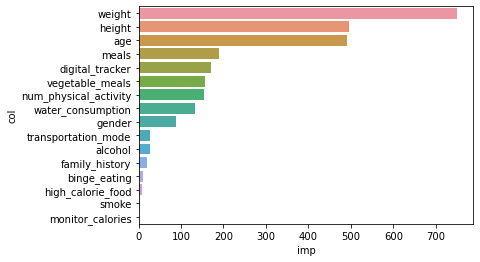

In [27]:
imp = pd.DataFrame()
imp['col'] = FEATURES
imp['imp'] = model.feature_importances_
imp = imp.sort_values(by='imp', ascending=False)


import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(imp['imp'], imp['col'])

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    Submit a CSV file with a header row plus each of the test entries, each on its own line. 

The file (`submissions.csv`) should have exactly 2 columns:

Column | Description
:---|:---
`id`  | Unique ID corresponding to the person
`outcome`  | Whether the person will develop a chronic disease in the future or not (1 - Yes, 0 - No)

In [28]:
test.head()

,id,gender,age,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode,height,weight
0,1500,0,19.0,1,1,1.078529,1.211606,2,0,2.568063,0,3.000000,0.817983,2,3,1.779882,80.0
1,1501,0,33.0,1,1,2.013782,2.625942,2,0,1.045586,0,0.553305,0.480214,1,0,1.730379,75.0
2,1502,0,23.0,1,1,3.000000,3.000000,2,0,2.000000,0,1.000000,0.000000,1,2,1.500000,55.0
3,1503,1,23.0,1,1,3.000000,2.510135,2,0,1.693362,0,0.769709,0.000000,1,3,1.849307,121.0
4,1504,0,21.0,1,1,3.000000,1.000000,2,0,2.000000,0,2.971832,0.000000,1,3,1.758628,78.0


In [29]:
test_preds = model.predict(test[FEATURES])

In [30]:
test['outcome'] = test_preds
test['outcome'].value_counts()

1    171
0    150
Name: outcome, dtype: int64

In [31]:
submission_df = test[['id', 'outcome']]

In [32]:
submission_df

,id,outcome
0,1500,0
1,1501,0
2,1502,0
3,1503,1
4,1504,0
...,...,...
316,1816,0
317,1817,1
318,1818,1
319,1819,0


In [33]:
# Submission
submission_df.to_csv('submissions.csv', index=False)